In [ ]:
#instala o pacote imdb
!pip install -q imdb-sqlite

In [ ]:
#instala o pacote 
#https://pypi.org/project/pycountry/
!pip install -q pycountry

In [4]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [9]:
##baixa o banco de dados do IMDB
## aguarde baixar tudo (maximo e aproximadamente 40min, dependendo da sua conexão e hardware)
%%time
!imdb-sqlite

UsageError: Line magic function `%%time` not found.


In [10]:
##conectando a banco de dados
conn = sqlite3.connect("imdb.db")

In [11]:
#extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_name' FROM sqlite_master WHERE type='table'", conn)

In [12]:
tabelas.head()

,Table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [13]:
#convertendo dataframe em lista
tabelas = tabelas["Table_name"].values.tolist()

In [14]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta,conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Análise Exploratória de Dados

## 1 - Quais são as categorias de filmes mais comuns no imdb?
Quais são os principais tipos(categorias) dos titulos(filmes)?

In [15]:
#Cria Consulta SQL
consulta1 = "SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type"

In [16]:
#Extraindo o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [17]:
display(resultado1)

,type,COUNT
0,movie,584886
1,radioEpisode,1
2,radioSeries,1
3,short,825456
4,tvEpisode,5981914
5,tvMiniSeries,38834
6,tvMovie,132513
7,tvSeries,212536
8,tvShort,10200
9,tvSpecial,33701


In [18]:
#Percentual de cada tipo
resultado1["percentual"] = (resultado1["COUNT"] / resultado1["COUNT"].sum())*100

In [19]:
display(resultado1)

,type,COUNT,percentual
0,movie,584886,7.162146
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,825456,10.108015
4,tvEpisode,5981914,73.250758
5,tvMiniSeries,38834,0.475537
6,tvMovie,132513,1.622671
7,tvSeries,212536,2.602582
8,tvShort,10200,0.124903
9,tvSpecial,33701,0.412681


In [20]:
#apresentando o resultado em gŕafico
outros = {}


#filtra o percentual em 5% e soma o total
outros["COUNT"] = resultado1[resultado1["percentual"] < 5]["COUNT"].sum()

#Gravando o percentual
outros["percentual"] = resultado1[resultado1["percentual"] < 5]["percentual"].sum()

outros["type"] = "outros"


In [21]:
outros

{'COUNT': 774095, 'percentual': 9.479080681200207, 'type': 'outros'}

In [22]:
#Filtra o dataframe/tabela de dados de resultados
resultado1 = resultado1[resultado1["percentual"]>5]

In [23]:
#adiciona o dataframe de outras categorias e ignora o index
resultado1 = resultado1.append(outros, ignore_index =True)

In [24]:
#ordena o resultado
resultado1 = resultado1.sort_values(by="COUNT", ascending=False)

In [25]:
#visualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,5981914,73.250758
1,short,825456,10.108015
3,outros,774095,9.479081
0,movie,584886,7.162146


In [26]:
#ajustando os labels usando listcomprehension
labels = [str(resultado1["type"][i])+ ' ' + '['+ str(round(resultado1["percentual"][i],2))+ '%' + ']' for i in resultado1.index]

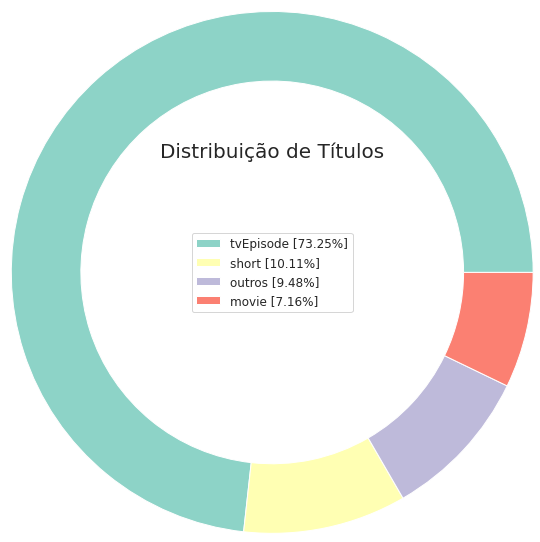

In [27]:
#Plot

#Mapa de Cores
#https://matplotlib.org/stablee/tutorials/color/colormaps.html
cs = cm.Set3(np.arange(100))
#cria a figura
f = plt.figure()
#Pie Plot
plt.pie(resultado1["COUNT"], labeldistance=1,radius=3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = "center", prop = {"size":12})
plt.title("Distribuição de Títulos", loc = "center", fontdict = {"fontsize":20, "fontweight":20})
plt.show()

## 2 - Qual o número de títulos por gênero? 

Calculando o número de filmes por gênero e entregar o resultado em valor percentual.

In [28]:
#Criando a consulta SQL
consulta2 = "SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres"

In [29]:
#Aplicando a query na conexão
resultado2 = pd.read_sql_query(consulta2,conn)

In [30]:
display(resultado2)

,genres,COUNT(*)
0,Action,13307
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1439,"Thriller,Western",39
1440,War,1249
1441,"War,Western",9
1442,Western,4008


In [31]:
#padronizando os nomes dos gêneros colocando todos em minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [32]:
#descartando valores ausentes
temp = resultado2['genres'].dropna()

## Usando o Countvectorize para contar o número de filmes em cada gênero

In [33]:
# Criando um vetor usando uma expressão regular para filtrar as strings
# https://docs.python.org/3.8/library/re.html
padrao = "(?u)\\b[\\w-]+\\b"

vetor = CountVectorizer(token_pattern=padrao, analyzer='word').fit(temp)

In [34]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [35]:
#aplicando a vetorização ao dataset sem os valores ausentes/NA
bag_generos = vetor.transform(temp)

In [36]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [37]:
# retornando os gêneros únicos
generos_uni = vetor.get_feature_names()

In [38]:
generos = pd.DataFrame(bag_generos.todense(), columns = generos_uni, index = temp.index)

In [39]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444 entries, 0 to 1443
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1444 non-null   int64
 1   adult        1444 non-null   int64
 2   adventure    1444 non-null   int64
 3   animation    1444 non-null   int64
 4   biography    1444 non-null   int64
 5   comedy       1444 non-null   int64
 6   crime        1444 non-null   int64
 7   documentary  1444 non-null   int64
 8   drama        1444 non-null   int64
 9   family       1444 non-null   int64
 10  fantasy      1444 non-null   int64
 11  film-noir    1444 non-null   int64
 12  game-show    1444 non-null   int64
 13  history      1444 non-null   int64
 14  horror       1444 non-null   int64
 15  music        1444 non-null   int64
 16  musical      1444 non-null   int64
 17  mystery      1444 non-null   int64
 18  n            1444 non-null   int64
 19  news         1444 non-null   int64
 20  reality-

In [40]:
#removendo a coluna 18
generos = generos.drop(columns='n', axis=0)

In [41]:
#calculando o percentual
gen_percent = 100 * pd.Series(generos.sum()).sort_values(ascending=False) / generos.shape[0]

In [42]:
gen_percent.head(10)

drama          18.421053
comedy         16.828255
documentary    15.997230
adventure      14.889197
action         14.612188
romance        13.504155
crime          13.019391
mystery        12.603878
thriller       12.396122
fantasy        12.257618
dtype: float64

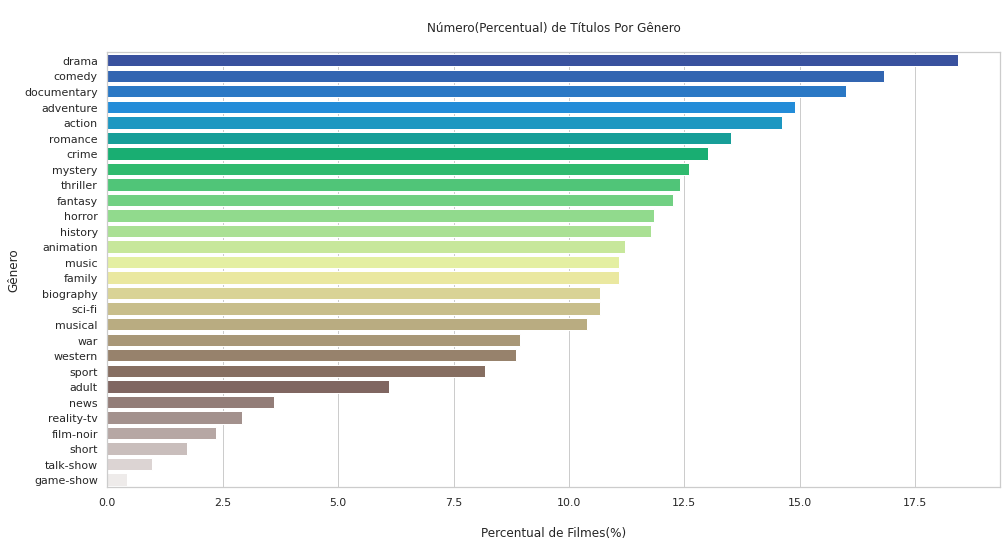

In [43]:
#Plot
# Mostrando os dados em gráfico
plt.figure(figsize = (16,8))
sns.barplot(x = gen_percent.values, y = gen_percent.index, orient="h", palette="terrain")
plt.ylabel("Gênero")
plt.xlabel("\nPercentual de Filmes(%)")
plt.title("\nNúmero(Percentual) de Títulos Por Gênero\n")
plt.show()

## Qual a mediana de avaliação dos filmes por gênero?
Mediana da avaliação dos filmess

In [44]:
#Cunsulta SQL
consulta3 = '''
            SELECT rating, genres FROM ratings
            JOIN titles ON ratings.title_id = titles.title_id\
            WHERE premiered <= 2022 AND type = 'movie'
            '''

In [45]:
#resultado
resultado3 = pd.read_sql_query(consulta3,conn)

In [46]:
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
266983,3.5,"Action,Adventure,Thriller"
266984,5.8,Thriller
266985,6.3,"Adventure,Drama,History"
266986,3.8,"Adventure,History,War"


In [47]:
#modularizando o código criando uma função para retornar os gêneros

def res_generos(df):
    df["genres"] = df["genres"].str.lower().values
    temp = df["genres"].dropna()
    vetor = CountVectorizer(token_pattern="(?u)\\b[\\w-]+\\b", analyzer="word").fit(temp)
    gen_uni = vetor.get_feature_names()
    gen_uni = [genre for genre in gen_uni if len(genre) > 1]
    return gen_uni

In [48]:
gen_uni = res_generos(resultado3)

In [49]:
gen_uni

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [50]:
# lista filmes por gênero
genero_counts = []
#lista filmes por avaliação
genero_ratings = []

In [51]:
#customizando as buscas 

for item in gen_uni:
    
    #retorna a contagem de filmes por gênero
    consulta = "SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE"+ "\""+"%"+item+"%"+"\" AND type=\'movie\'"
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    #retorna a avaliação de filmes por gênero
    consulta = "SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE" + "\""+"%"+item+"%"+"\" AND type=\'movie\'"
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado["rating"]))

In [52]:
#Preparando o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings["genres"] = gen_uni
df_genero_ratings["count"] = genero_counts
df_genero_ratings["rating"] = genero_ratings

In [53]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,28699,5.8
1,adult,4075,5.8
2,adventure,17636,6.0
3,animation,4657,6.4
4,biography,8023,7.0
5,comedy,66583,6.0
6,crime,23036,6.1
7,documentary,39074,7.3
8,drama,118531,6.3
9,family,10153,6.3


In [54]:
#drop item 18 (news)
df_genero_ratings = df_genero_ratings.drop(index=18)

In [55]:
df_genero_ratings = df_genero_ratings.sort_values(by = "rating",ascending=False)

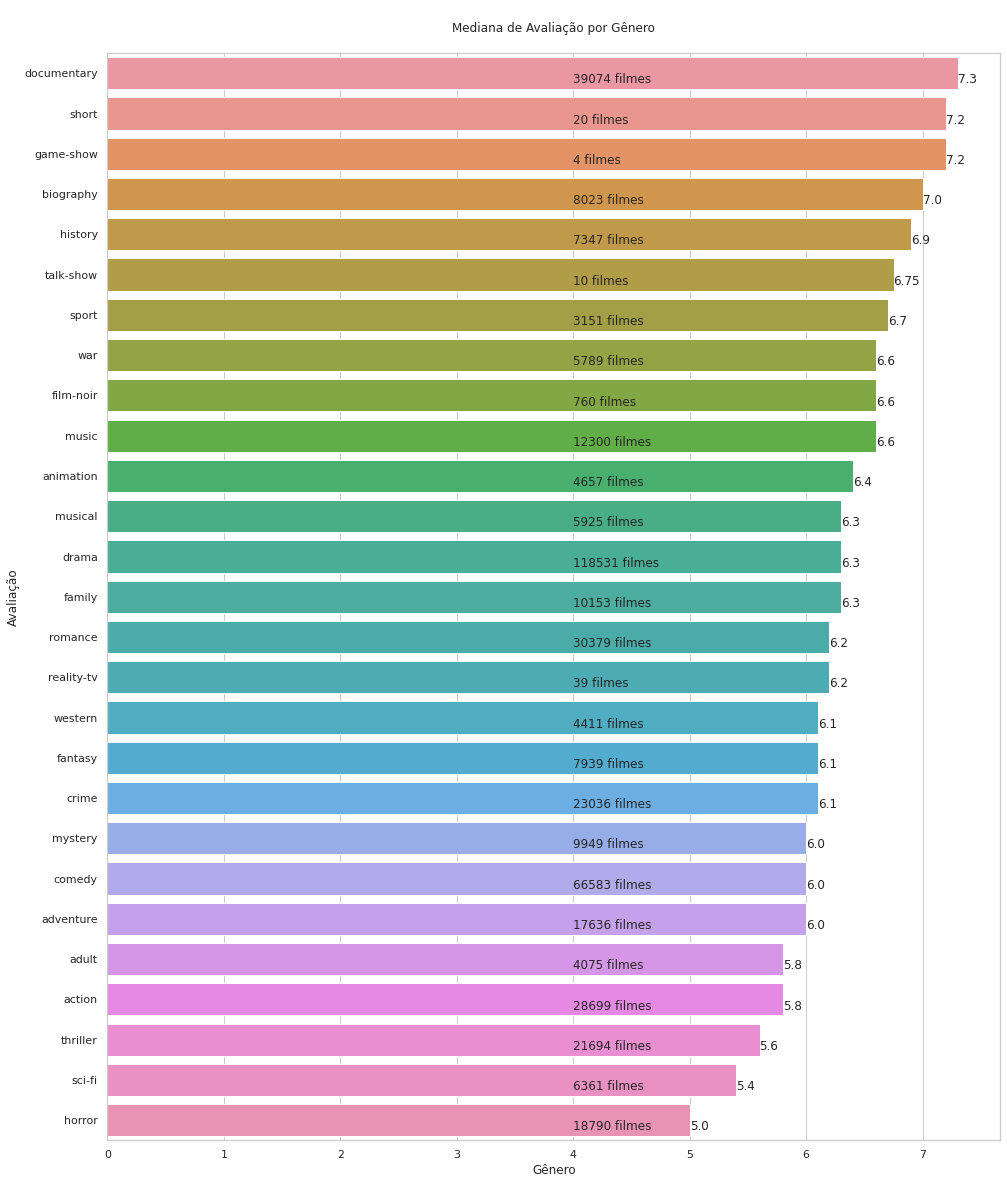

In [56]:
#Plot

#figura
plt.figure(figsize=(16,20))

#Barplot

sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

#textos dos gráficos

for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, i + 0.25, str(df_genero_ratings["count"][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]], i + 0.25, round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))


plt.xlabel("Gênero")
plt.ylabel("Avaliação")
plt.title("\nMediana de Avaliação por Gênero\n")
plt.show()